In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
 
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
 
from keras.datasets import cifar10
from keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [2]:
SEED_VALUE = 42 
# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
 
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


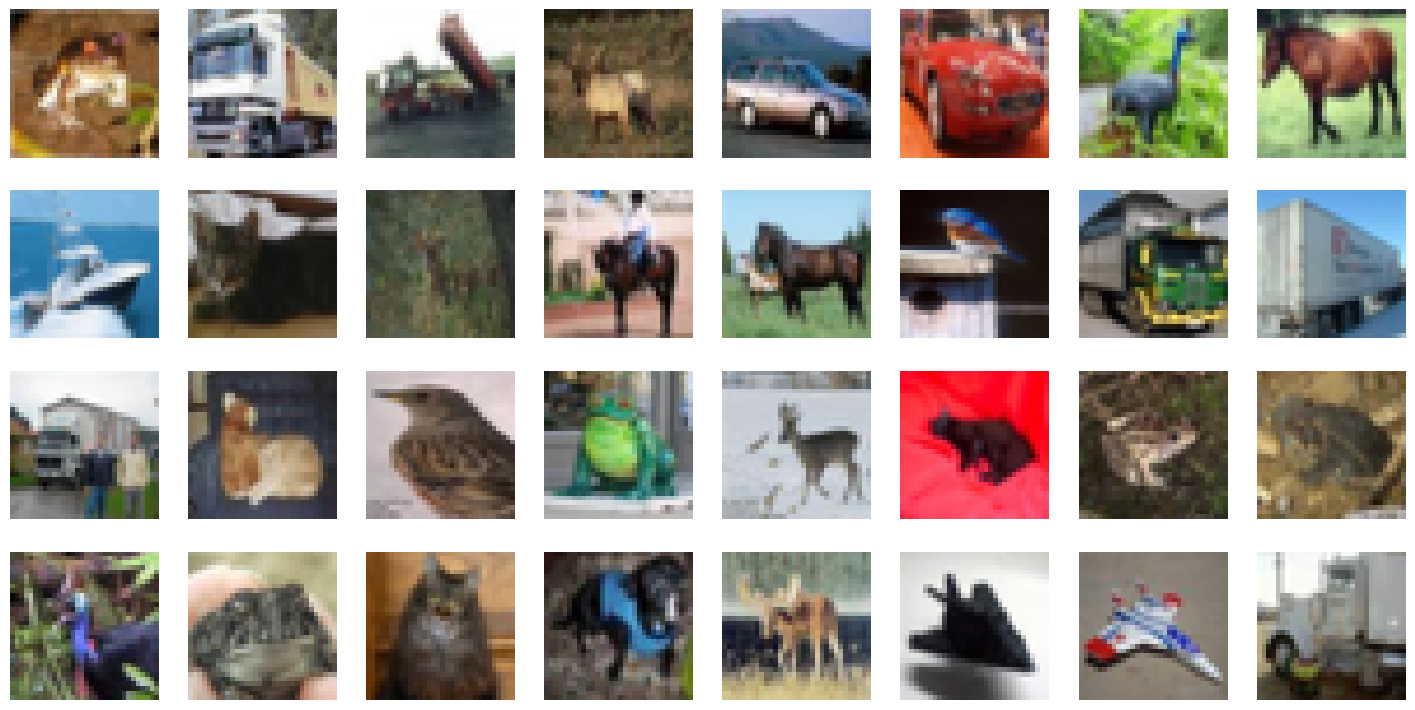

In [4]:
plt.figure(figsize=(18, 9))
 
num_rows = 4
num_cols = 8
 
# plot each of the images in the batch and the associated ground truth labels.
for i in range(num_rows*num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i,:,:])
    plt.axis("off")

In [5]:
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32") / 255
 
# Change the labels from integer to categorical data.
print('Original (integer) label for the first training sample: ', y_train[0])
 
# Convert labels to one-hot encoding.
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)
 
print('After conversion to categorical one-hot encoded labels: ', y_train[0])

Original (integer) label for the first training sample:  [6]
After conversion to categorical one-hot encoded labels:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:   int = 32
    IMG_WIDTH:    int = 32
    NUM_CHANNELS: int = 3
     
@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:        int = 31
    BATCH_SIZE:    int = 256
    LEARNING_RATE: float = 0.001

In [7]:
def cnn_model(input_shape=(32, 32, 3)):
     
    model = Sequential()
     
    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
     
    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
     
    return model

In [8]:

# Create the model.
model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [9]:
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'],
             )

In [11]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3,  # Number of epochs with no improvement after which training will be stopped
                           restore_best_weights=True)  # Restores model to best weights after early stopping

history = model.fit(X_train,
                    y_train,
                    batch_size=TrainingConfig.BATCH_SIZE, 
                    epochs=TrainingConfig.EPOCHS, 
                    verbose=1, 
                    validation_split=0.3,
                    callbacks=[early_stop])

Epoch 1/31
137/137 [==============================] - 131s 953ms/step - loss: 1.0775 - accuracy: 0.6174 - val_loss: 1.0049 - val_accuracy: 0.6416
Epoch 2/31
137/137 [==============================] - 138s 1s/step - loss: 1.0196 - accuracy: 0.6378 - val_loss: 0.8928 - val_accuracy: 0.6877
Epoch 3/31
137/137 [==============================] - 137s 1s/step - loss: 0.9597 - accuracy: 0.6573 - val_loss: 0.9312 - val_accuracy: 0.6779
Epoch 4/31
137/137 [==============================] - 137s 997ms/step - loss: 0.9259 - accuracy: 0.6730 - val_loss: 0.8834 - val_accuracy: 0.6917
Epoch 5/31
137/137 [==============================] - 142s 1s/step - loss: 0.8826 - accuracy: 0.6892 - val_loss: 0.9630 - val_accuracy: 0.6625
Epoch 6/31
137/137 [==============================] - 170s 1s/step - loss: 0.8435 - accuracy: 0.7031 - val_loss: 0.8404 - val_accuracy: 0.7036
Epoch 7/31
137/137 [==============================] - 165s 1s/step - loss: 0.8094 - accuracy: 0.7118 - val_loss: 0.7982 - val_accuracy: 

In [12]:
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]
     
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

NameError: name 'plot_results' is not defined

In [13]:
model.save('cnn')
model.save('cnn.h5')

INFO:tensorflow:Assets written to: cnn\assets


INFO:tensorflow:Assets written to: cnn\assets
c:\Users\aakas\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
     
    fig, ax = plt.subplots(figsize=(15, 4))
 
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
         
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
     
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

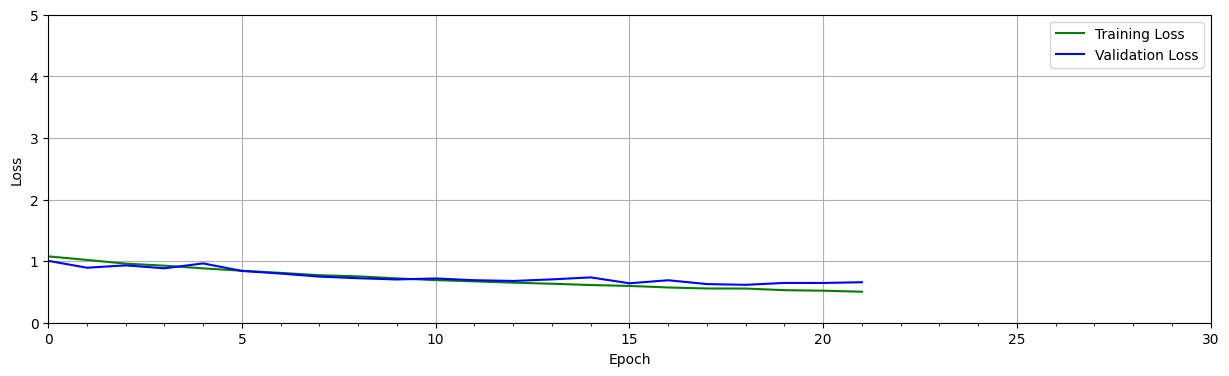

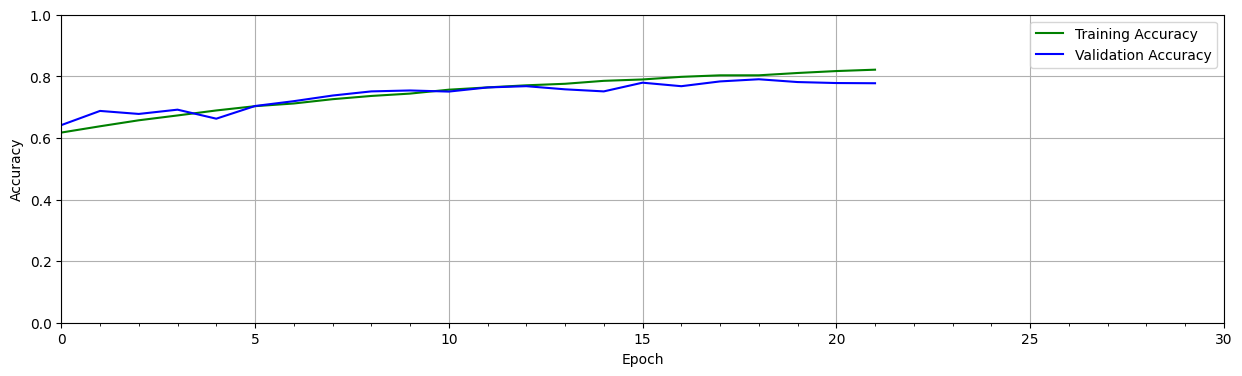

In [15]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])